# Clustering Analysis

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
from statsmodels.stats.oneway import anova_oneway
import pingouin as pg

## Load and Preprocess Data

In [100]:
feature_data = pd.read_csv('feature_data_filtered.csv')

In [101]:
clear_features = {
    'C&S_3PT_PPS': 'Catch-and-Shoot-3 Points-Per-Shot',
    'OTD_PPS': 'Off-the-Dribble Points-Per-Shot',
    'C&S_3PT_ATT_PG': 'Catch-and-Shoot-3 Attempts Per Game',
    'OTD_ATT_PG': 'Off-the-Dribble Attempts Per Game',
    'Shot_diet_C&S': 'Catch-and-Shoot Frequency',
    'Shot_diet_OTD': 'Off-the-Dribble Frequency',
}

In [102]:
# Drop noisy features, I planned on including them in the clustering but they didn't add much value and made the clusters less interpretable
cluster_data = feature_data.drop(columns=['Name', 'C&S_Guarded_prop', 'Length'])
cluster_data.rename(columns=clear_features, inplace=True)
cluster_features = cluster_data.columns

In [103]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

## Akaike Information Criterion (AIC)

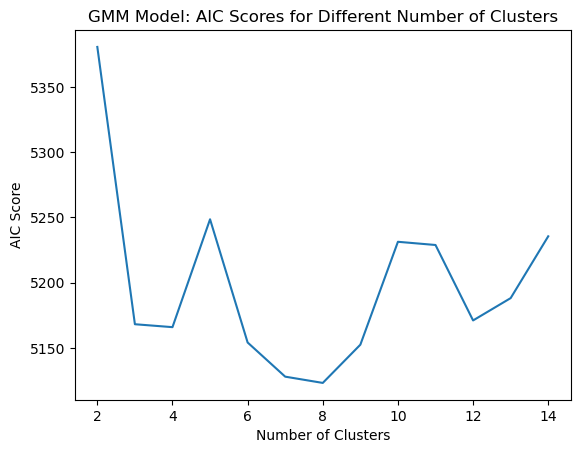

In [104]:
# Plot the AIC for a range of number of clusters to find the optimal number of clusters
n_clusters = range(2, 15)
aic_scores = []

for k in n_clusters:
    gmm_k = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_k.fit(X_scaled)
    aic_scores.append(gmm_k.aic(X_scaled))


plt.plot(n_clusters, aic_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('AIC Score')
plt.title('GMM Model: AIC Scores for Different Number of Clusters')
plt.show()

## Initialize and Fit the GMM

In [105]:
gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

cluster_labels = gmm.predict(X_scaled)


df_clustered = cluster_data.copy()
df_clustered['Cluster'] = cluster_labels

In [106]:
centroid_z_scores = pd.DataFrame(gmm.means_, columns=cluster_features)
centroid_z_scores['Cluster'] = range(8)
centroid_z_scores.set_index('Cluster', inplace=True)

## Centroid Analysis

Plot the centroids of each cluster in the form of a heatmap and line graph. The goal here is to ensure that the centroids are distinct and meaningful.

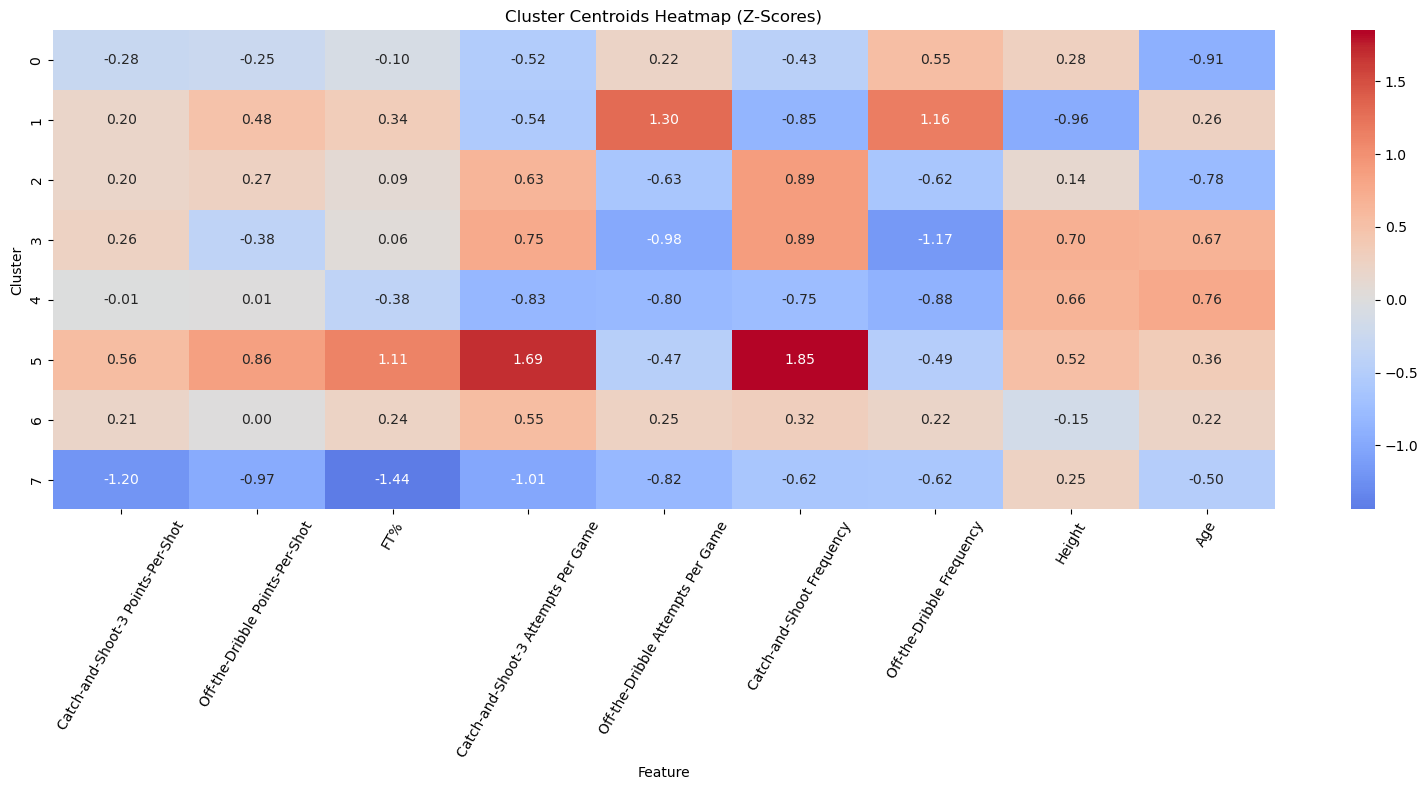

In [107]:
# Heatmap of cluster centroids
plt.figure(figsize=(16,8))
sns.heatmap(centroid_z_scores, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.xticks(rotation=60)
plt.title("Cluster Centroids Heatmap (Z-Scores)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

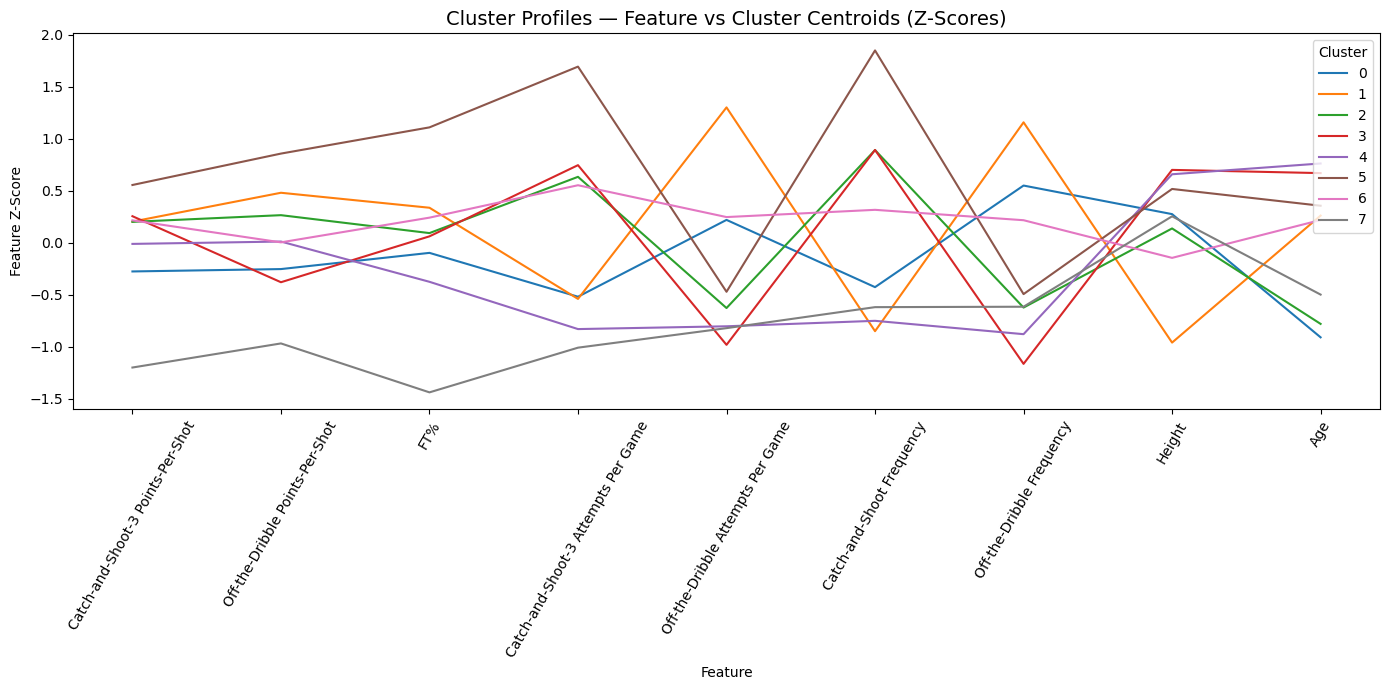

In [108]:
# Loop through each cluster and plot the z-scores for each feature
plt.figure(figsize=(14,7))

for cluster in centroid_z_scores.index:
    plt.plot(centroid_z_scores.columns, centroid_z_scores.loc[cluster], label = cluster)

plt.xticks(rotation=60)
plt.ylabel('Feature Z-Score')
plt.xlabel('Feature')
plt.title('Cluster Profiles — Feature vs Cluster Centroids (Z-Scores)', fontsize=14)
plt.legend(title='Cluster', loc='upper right')
plt.tight_layout()
plt.show()

## Archetype Labeling

Based on centroid data and manually looking at the players in each cluster, we can label the archetypes

In [109]:
# Add names back to the cluster dataframe and z-score cluster dataframe
full_df = feature_data[['Name']].merge(df_clustered, left_index=True, right_index=True, how='left')

X_scaled_df = pd.DataFrame(X_scaled, columns=cluster_features)
X_scaled_df["Cluster"] = cluster_labels
full_z_df = feature_data[['Name']].merge(X_scaled_df, left_index=True, right_index=True, how='left')

In [110]:
shooting_archetypes = {
    0: 'Young, Unproven Shooter',
    1: 'High-Volume, Off the Dribble Guard',
    2: 'Young, Efficient, Catch-and-Shoot Heavy',
    3: 'Solid Catch-and-Shoot Only Veteran Forward',
    4: 'Average Efficiency, Low Volume Forward',
    5: 'Elite Efficiency, Catch-and-Shoot Specialist',
    6: 'High Volume, Efficient, Balanced Shooter',
    7: 'Poor All Around Shooter'
}

typical_members = {
    0: "Anthony Black, Jaden Ivey, Andrew Wiggins",
    1: "Cade Cunningham, Jamal Murray, Devonte Graham",
    2: "Devin Booker, Moses Moody, Kevin Huerter",
    3: "Keegan Murray, DeAndre Hunter, Georges Niang",
    4: "Rui Hachimura, Chet Holmgren, Tari Eason",
    5: "Trey Murphy III, Isaiah Joe, Cameron Johnson",
    6: "Tyler Herro, Tyrese Haliburton, Buddy Hield",
    7: "Andre Roberson, Josh Jackson, Jarace Walker"
}

In [111]:
centroid_z_archetypes = centroid_z_scores.copy()
centroid_z_archetypes['Archetype'] = centroid_z_archetypes.index.map(shooting_archetypes)
centroid_z_archetypes.set_index('Archetype', inplace=True)

In [112]:
full_df['Archetype'] = full_df['Cluster'].map(shooting_archetypes)

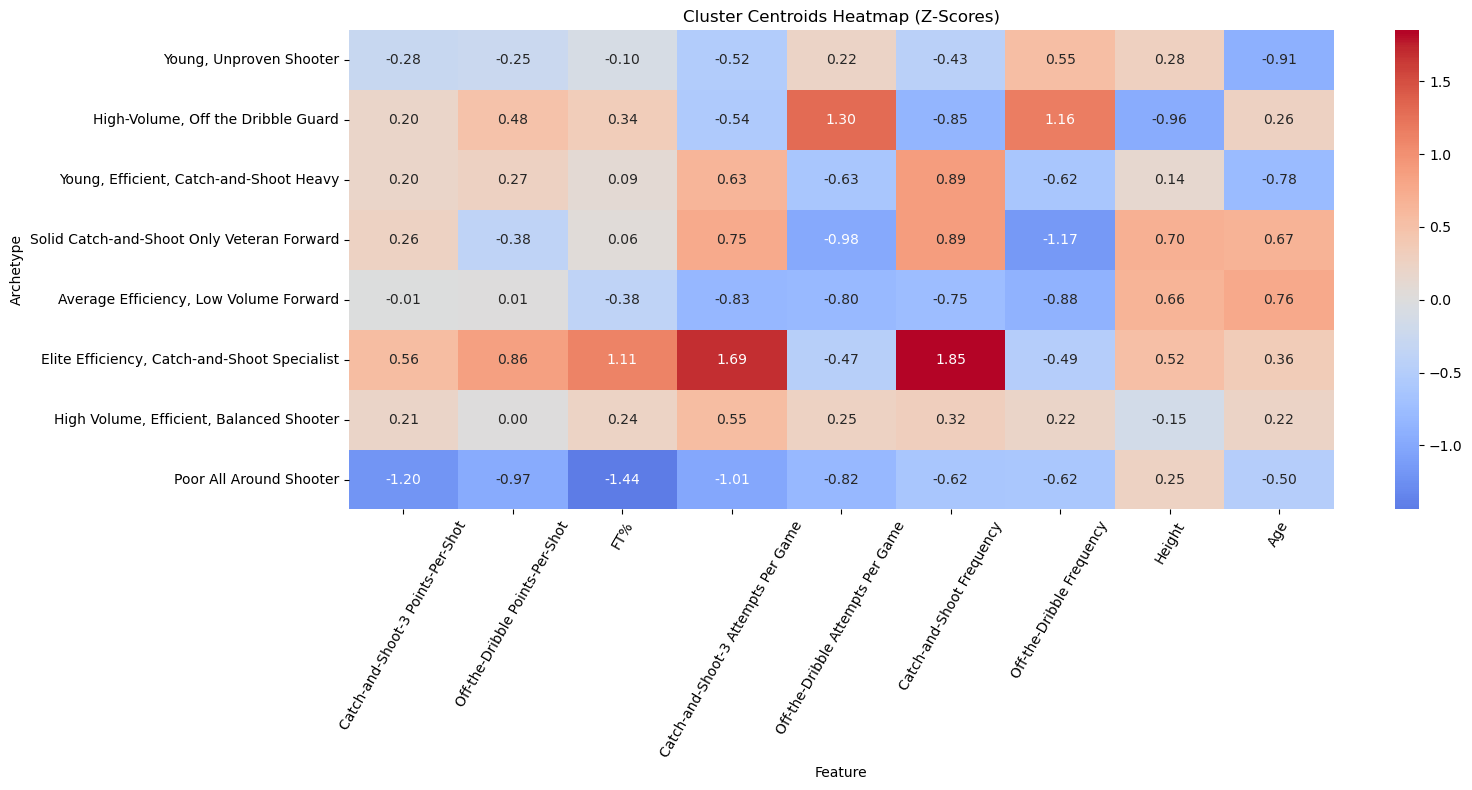

In [113]:
# Replot the heatmap with archetype labels
plt.figure(figsize=(16,8))
sns.heatmap(centroid_z_archetypes, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.xticks(rotation=60)
plt.title("Cluster Centroids Heatmap (Z-Scores)")
plt.ylabel("Archetype")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

In [114]:
#table of archetypes and typical members
archetype_table = pd.DataFrame(shooting_archetypes.items(), columns=['Cluster', 'Archetype'])
archetype_table['Typical Members'] = archetype_table['Cluster'].map(typical_members)
archetype_table["Number of Players"] = archetype_table['Cluster'].map(full_df['Cluster'].value_counts())
archetype_table.drop(columns=['Cluster'], inplace=True)
archetype_table

,Archetype,Typical Members,Number of Players
0,"Young, Unproven Shooter","Anthony Black, Jaden Ivey, Andrew Wiggins",35
1,"High-Volume, Off the Dribble Guard","Cade Cunningham, Jamal Murray, Devonte Graham",61
2,"Young, Efficient, Catch-and-Shoot Heavy","Devin Booker, Moses Moody, Kevin Huerter",30
3,Solid Catch-and-Shoot Only Veteran Forward,"Keegan Murray, DeAndre Hunter, Georges Niang",32
4,"Average Efficiency, Low Volume Forward","Rui Hachimura, Chet Holmgren, Tari Eason",21
5,"Elite Efficiency, Catch-and-Shoot Specialist","Trey Murphy III, Isaiah Joe, Cameron Johnson",16
6,"High Volume, Efficient, Balanced Shooter","Tyler Herro, Tyrese Haliburton, Buddy Hield",58
7,Poor All Around Shooter,"Andre Roberson, Josh Jackson, Jarace Walker",30


# Exploring NBA Success by Archetype

In [115]:
# Load NBA outcome data
nba_otd = pd.read_csv('otd_target_data.csv')
nba_cas = pd.read_csv('cas_target_data.csv')

In [116]:
full_df_nba = full_df.merge(nba_otd, left_on='Name', right_on='Player', how='left')
full_df_nba = full_df_nba.merge(nba_cas, left_on='Name', right_on='Player', how='left')
full_df_nba.rename(columns={'NBA_C&S_PPS': 'NBA Catch-and-Shoot Points-Per-Shot', 
                            'NBA_OTD_PPS': 'NBA Off-the-Dribble Points-Per-Shot'}, inplace=True)

## Visualizing NBA Shooting Success

### Shooting Success Distributions for each archetype

Text(0.5, 1.0, 'NBA Catch-and-Shoot Points-Per-Shot by College Archetype')

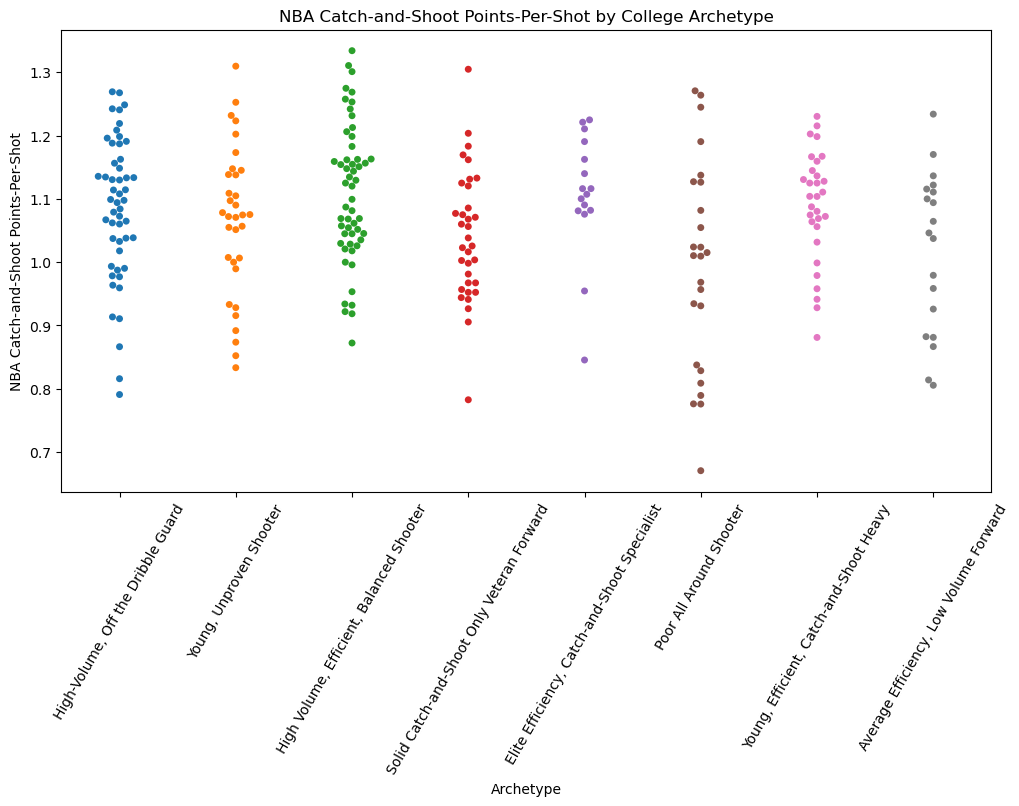

In [117]:
plt.figure(figsize=(12,6))
sns.swarmplot(data=full_df_nba, x='Archetype', y='NBA Catch-and-Shoot Points-Per-Shot', hue='Archetype')
plt.xticks(rotation=60)
plt.title('NBA Catch-and-Shoot Points-Per-Shot by College Archetype')

Text(0.5, 1.0, 'NBA Off-the-Dribble Points-Per-Shot by College Archetype')

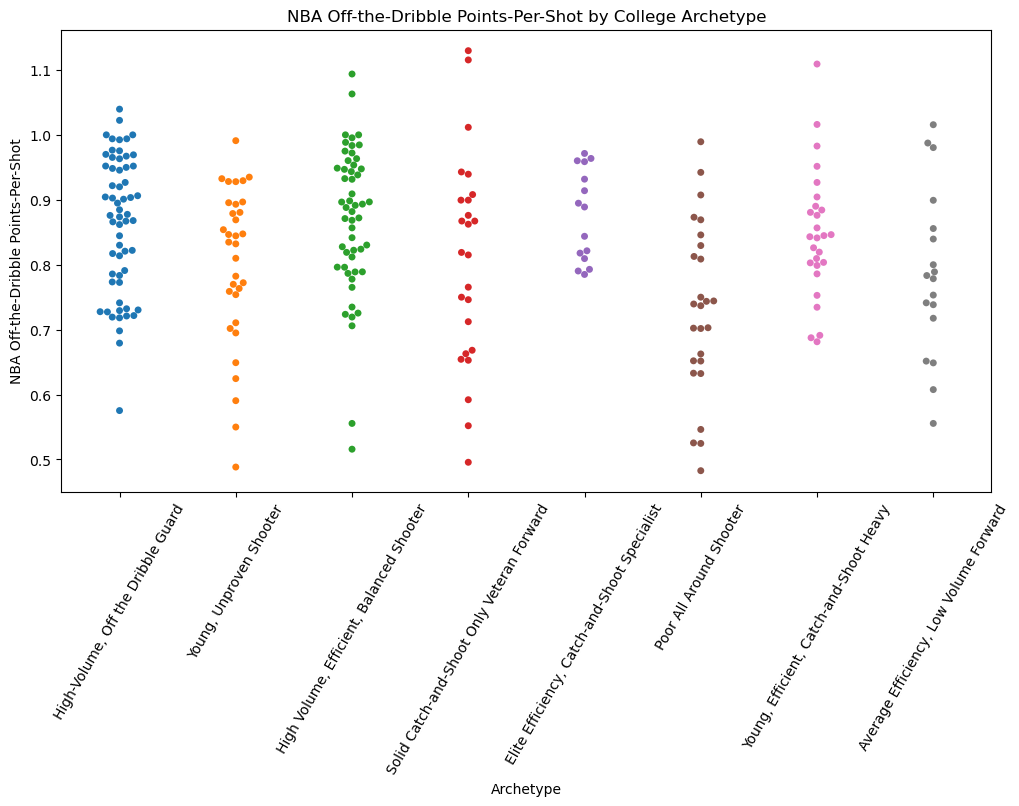

In [118]:
plt.figure(figsize=(12,6))
sns.swarmplot(data=full_df_nba, x='Archetype', y='NBA Off-the-Dribble Points-Per-Shot', hue='Archetype')
plt.xticks(rotation=60)
plt.title('NBA Off-the-Dribble Points-Per-Shot by College Archetype')

In [119]:
full_df_nba['Archetype_cluster'] = full_df_nba['Archetype'] + ' (' + full_df_nba['Cluster'].astype(str) + ')'

In [120]:
archetype_CAS_table = full_df_nba.groupby(['Archetype_cluster', 'Cluster'])['NBA Catch-and-Shoot Points-Per-Shot'].agg(['mean', 'var'])
archetype_CAS_table = archetype_CAS_table.reset_index().sort_values(by='Cluster').drop(columns='Cluster')
archetype_CAS_table.set_index('Archetype_cluster', inplace=True)
archetype_CAS_table.rename(columns={'mean': 'Mean Catch-and-Shoot Points-Per-Shot', 
                                    'var': 'Catch-and-Shoot Points-Per-Shot Variance'}, inplace=True)
archetype_CAS_table

,Mean Catch-and-Shoot Points-Per-Shot,Catch-and-Shoot Points-Per-Shot Variance
Archetype_cluster,,
"Young, Unproven Shooter (0)",1.064523,0.014034
"High-Volume, Off the Dribble Guard (1)",1.085309,0.012563
"Young, Efficient, Catch-and-Shoot Heavy (2)",1.089007,0.007735
Solid Catch-and-Shoot Only Veteran Forward (3),1.041492,0.010446
"Average Efficiency, Low Volume Forward (4)",1.018128,0.016048
"Elite Efficiency, Catch-and-Shoot Specialist (5)",1.107422,0.009547
"High Volume, Efficient, Balanced Shooter (6)",1.108482,0.011752
Poor All Around Shooter (7),0.994322,0.027419


In [121]:
archetype_OTD_table = full_df_nba.groupby(['Archetype_cluster', 'Cluster'])['NBA Off-the-Dribble Points-Per-Shot'].agg(['mean', 'var'])
archetype_OTD_table = archetype_OTD_table.reset_index().sort_values(by='Cluster').drop(columns='Cluster')
archetype_OTD_table.set_index('Archetype_cluster', inplace=True)
archetype_OTD_table.rename(columns={'mean': 'Mean Off-the-Dribble Points-Per-Shot', 
                                    'var': 'Off-the-Dribble Points-Per-Shot Variance'}, inplace=True)
archetype_OTD_table

,Mean Off-the-Dribble Points-Per-Shot,Off-the-Dribble Points-Per-Shot Variance
Archetype_cluster,,
"Young, Unproven Shooter (0)",0.801130,0.014713
"High-Volume, Off the Dribble Guard (1)",0.863461,0.011116
"Young, Efficient, Catch-and-Shoot Heavy (2)",0.846196,0.009722
Solid Catch-and-Shoot Only Veteran Forward (3),0.808184,0.026354
"Average Efficiency, Low Volume Forward (4)",0.785709,0.016691
"Elite Efficiency, Catch-and-Shoot Specialist (5)",0.876256,0.005009
"High Volume, Efficient, Balanced Shooter (6)",0.869862,0.012749
Poor All Around Shooter (7),0.731150,0.017509


### Statistical Tests

In [122]:
CAS_ANOVA_df = full_df_nba[['Archetype', 'NBA Catch-and-Shoot Points-Per-Shot']].dropna()

welch_result = anova_oneway(CAS_ANOVA_df['NBA Catch-and-Shoot Points-Per-Shot'], groups=CAS_ANOVA_df['Archetype'], use_var='unequal')

print(welch_result)

statistic = 2.970115032634472
pvalue = 0.007666235717319664
df = (7.0, 87.45277316553445)
df_num = 7.0
df_denom = 87.45277316553445
nobs_t = 262.0
n_groups = 8
means = [1.01812768 1.10742215 1.10848161 1.08530897 0.99432178 1.04149205
     1.08900696 1.0645233 ]
nobs = [19. 16. 54. 51. 25. 34. 30. 33.]
vars_ = [0.01604785 0.00954671 0.01175172 0.01256318 0.02741906 0.01044566
     0.00773469 0.01403387]
use_var = unequal
welch_correction = True
tuple = (2.970115032634472, 0.007666235717319664)


In [123]:
CAS_gh_df = full_df_nba[['Cluster', 'NBA Catch-and-Shoot Points-Per-Shot']].dropna()

gh_CAS = pg.pairwise_gameshowell(data=CAS_gh_df, dv='NBA Catch-and-Shoot Points-Per-Shot', between='Cluster')

gh_CAS[gh_CAS["pval"] < 0.05]

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges


In [124]:
OTD_ANOVA_df = full_df_nba[['Archetype', 'NBA Off-the-Dribble Points-Per-Shot']].dropna()

welch_result = anova_oneway(OTD_ANOVA_df['NBA Off-the-Dribble Points-Per-Shot'], groups=OTD_ANOVA_df['Archetype'], use_var='unequal')

print(welch_result)

statistic = 4.874423499401853
pvalue = 0.00012233783868034295
df = (7.0, 82.73376883251531)
df_num = 7.0
df_denom = 82.73376883251531
nobs_t = 257.0
n_groups = 8
means = [0.78570874 0.87625552 0.86986194 0.86346086 0.73115048 0.8081836
     0.84619619 0.8011302 ]
nobs = [18. 15. 53. 60. 26. 25. 27. 33.]
vars_ = [0.01669071 0.00500918 0.01274888 0.01111593 0.01750887 0.02635359
     0.00972209 0.01471305]
use_var = unequal
welch_correction = True
tuple = (4.874423499401853, 0.00012233783868034295)


In [125]:
OTD_gh_df = full_df_nba[['Cluster', 'NBA Off-the-Dribble Points-Per-Shot']].dropna()

gh_OTD = pg.pairwise_gameshowell(data=OTD_gh_df, dv='NBA Off-the-Dribble Points-Per-Shot', between='Cluster')

gh_OTD[gh_OTD["pval"] < 0.05]

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
12,1,7,0.863461,0.73115,0.132310,0.029303,4.515204,39.384682,0.001332,1.149226
17,2,7,0.846196,0.73115,0.115046,0.032148,3.578625,46.185804,0.017253,0.974112
26,5,7,0.876256,0.73115,0.145105,0.031739,4.571823,38.872527,0.001147,1.246978
27,6,7,0.869862,0.73115,0.138711,0.030232,4.588260,43.388268,0.000920,1.148856


## Are Certain Archetypes Over/Under Rated in the Draft?

In [126]:
stathead_data = pd.read_csv('stathead_data.csv')

In [127]:
name_corrections = {
'De Aaron Fox': "De'Aaron Fox",
'GG Jackson': 'GG Jackson II',
'James Ennis': 'James Ennis III',
'TJ Warren': 'T.J. Warren',
'Nick Smith Jr': 'Nick Smith Jr.',
'Andrew  Wiggins': 'Andrew Wiggins',
'DeAndre Hunter': "De'Andre Hunter",
'DeAndre Bembry': "DeAndre' Bembry",
'DAngelo Russell': "D'Angelo Russell",
'PJ Hairston': 'P.J. Hairston',
'KJ McDaniels': 'K.J. McDaniels',
'Frank Mason': 'Frank Mason III',
'Wesley Iwundu': 'Wes Iwundu',
'Jabari Smith II': 'Jabari Smith Jr.',
'Terry Rozier III': 'Terry Rozier',
'DeAnthony Melton': "De'Anthony Melton",
'Devonte Graham': "Devonte' Graham",
}

In [128]:
full_df['Updated_Name'] = full_df['Name'].copy()
full_df['Updated_Name'] = full_df['Updated_Name'].replace(name_corrections)

In [129]:
advanced_data = full_df.merge(stathead_data, left_on='Updated_Name', right_on='Player', how='left')
advanced_data.dropna(inplace=True)

/var/folders/6s/3gssyb0s1p12zf4hx7ftxw0w0000gn/T/ipykernel_38203/2048435397.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="College Player Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")


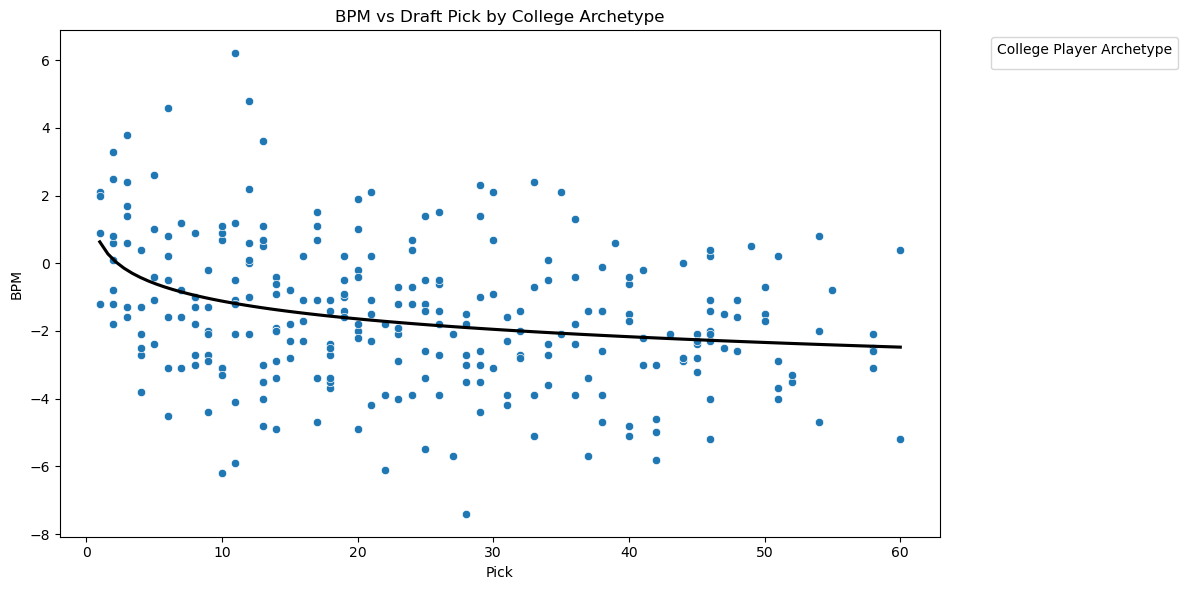

In [152]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(data=advanced_data, x='Pick', y='BPM')
sns.regplot(data=advanced_data, x='Pick', y='BPM', scatter=False, logx = True, color='black', ci=None)

plt.title('BPM vs Draft Pick by College Archetype')

ax.legend(title="College Player Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [131]:
sorted_data = advanced_data.sort_values(by='Pick')

BPM_fit_line = sm.nonparametric.lowess(sorted_data['BPM'], sorted_data['Pick'], frac=0.3)

fit_array = np.array(BPM_fit_line)

fit_array_x = fit_array[:, 0]
fit_array_y = fit_array[:, 1]

sorted_data['Expected_BPM'] = np.interp(sorted_data['Pick'], fit_array_x, fit_array_y)

sorted_data['BPM_Residual'] = sorted_data['BPM'] - sorted_data['Expected_BPM']

In [132]:
value_table = sorted_data.groupby('Archetype')['BPM_Residual'].agg(['mean', 'var']).round(2).sort_values(by='mean', ascending=False)
pick_bpm_table = sorted_data.groupby('Archetype')["Pick"].mean().round(2)
draft_value_table = value_table.merge(pick_bpm_table, left_index=True, right_index=True)
draft_value_table.rename(columns={'mean': 'BPM Over Expected', 'var': 'BPM Variance', 'Pick': 'Avg Draft Position'}, inplace=True)

In [133]:
draft_value_table.style.background_gradient(cmap='coolwarm', subset=['BPM Over Expected']).format(precision=2)

,BPM Over Expected,BPM Variance,Avg Draft Position
Archetype,,,
"Average Efficiency, Low Volume Forward",0.55,2.58,27.75
"High Volume, Efficient, Balanced Shooter",0.44,4.86,27.10
"Elite Efficiency, Catch-and-Shoot Specialist",0.21,5.52,25.12
"High-Volume, Off the Dribble Guard",0.13,4.73,22.64
Solid Catch-and-Shoot Only Veteran Forward,0.10,2.40,29.00
Poor All Around Shooter,-0.33,2.21,25.93
"Young, Efficient, Catch-and-Shoot Heavy",-0.34,2.82,19.03
"Young, Unproven Shooter",-0.55,4.94,16.94


### Finding the right fit of BPM and Draft Pick

In [134]:
fit_data = advanced_data[["Pick", "BPM"]]
fit_data['log_pick'] = np.log(fit_data['Pick'])
fit_data['pick_squared'] = fit_data['Pick'] ** 2

/var/folders/6s/3gssyb0s1p12zf4hx7ftxw0w0000gn/T/ipykernel_38203/4058043189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_data['log_pick'] = np.log(fit_data['Pick'])
/var/folders/6s/3gssyb0s1p12zf4hx7ftxw0w0000gn/T/ipykernel_38203/4058043189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_data['pick_squared'] = fit_data['Pick'] ** 2


In [135]:
X_linear = sm.add_constant(fit_data['Pick'])
model_linear = sm.OLS(fit_data['BPM'], X_linear).fit()

In [136]:
X_log = sm.add_constant(fit_data['log_pick'])
model_log = sm.OLS(fit_data['BPM'], X_log).fit()

In [137]:
X_quad = sm.add_constant(fit_data[['Pick', 'pick_squared']])
model_quad = sm.OLS(fit_data['BPM'], X_quad).fit()

In [138]:
model_comparison = pd.DataFrame({
    'Model': ['Linear', 'Logarithmic', 'Quadratic'],
    'AIC': [model_linear.aic, model_log.aic, model_quad.aic],
    'BIC': [model_linear.bic, model_log.bic, model_quad.bic]
})

In [139]:
model_comparison

,Model,AIC,BIC
0,Linear,1192.791159,1200.060739
1,Logarithmic,1184.055456,1191.325035
2,Quadratic,1188.734955,1199.639323


In [140]:
advanced_data = advanced_data.merge(model_log.resid.rename('Log_Residuals'), left_index=True, right_index=True)

In [141]:
value_table = advanced_data.groupby('Archetype')['Log_Residuals'].agg(['mean', 'var']).round(2).sort_values(by='mean', ascending=False)
pick_bpm_table = advanced_data.groupby('Archetype')["Pick"].mean().round(2)
draft_value_table = value_table.merge(pick_bpm_table, left_index=True, right_index=True)
draft_value_table.rename(columns={'mean': 'BPM Over Expected', 'var': 'BPM Variance', 'Pick': 'Avg Draft Position'}, inplace=True)

In [142]:
draft_value_table.style.background_gradient(cmap='coolwarm', subset=['BPM Over Expected']).format(precision=2)

,BPM Over Expected,BPM Variance,Avg Draft Position
Archetype,,,
"Average Efficiency, Low Volume Forward",0.56,2.69,27.75
"High Volume, Efficient, Balanced Shooter",0.38,4.75,27.10
Solid Catch-and-Shoot Only Veteran Forward,0.12,2.49,29.00
"Elite Efficiency, Catch-and-Shoot Specialist",0.11,5.57,25.12
"High-Volume, Off the Dribble Guard",0.07,4.84,22.64
Poor All Around Shooter,-0.33,2.12,25.93
"Young, Efficient, Catch-and-Shoot Heavy",-0.39,2.92,19.03
"Young, Unproven Shooter",-0.60,4.80,16.94


/var/folders/6s/3gssyb0s1p12zf4hx7ftxw0w0000gn/T/ipykernel_38203/3863590027.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="College Player Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")


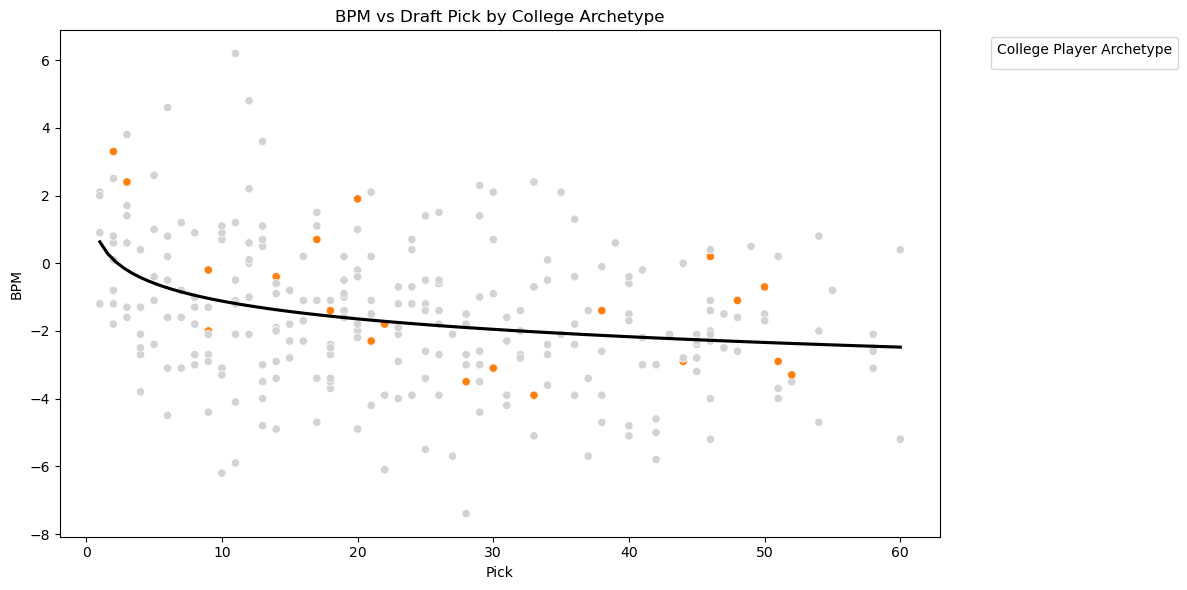

In [150]:
archetype = "Average Efficiency, Low Volume Forward"

advanced_data["Color"] = advanced_data["Archetype"].apply(lambda x: 'tab:blue' if x == archetype else 'lightgrey')


plt.figure(figsize=(12,6))
ax = sns.scatterplot(data=advanced_data, x='Pick', y='BPM', hue='Color', palette=['lightgrey', 'tab:orange'], legend=False)
sns.regplot(data=advanced_data, x='Pick', y='BPM', scatter=False, logx = True, color='black', ci=None)

plt.title('BPM vs Draft Pick by College Archetype')

ax.legend(title="College Player Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

/var/folders/6s/3gssyb0s1p12zf4hx7ftxw0w0000gn/T/ipykernel_38203/479087838.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="College Player Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")


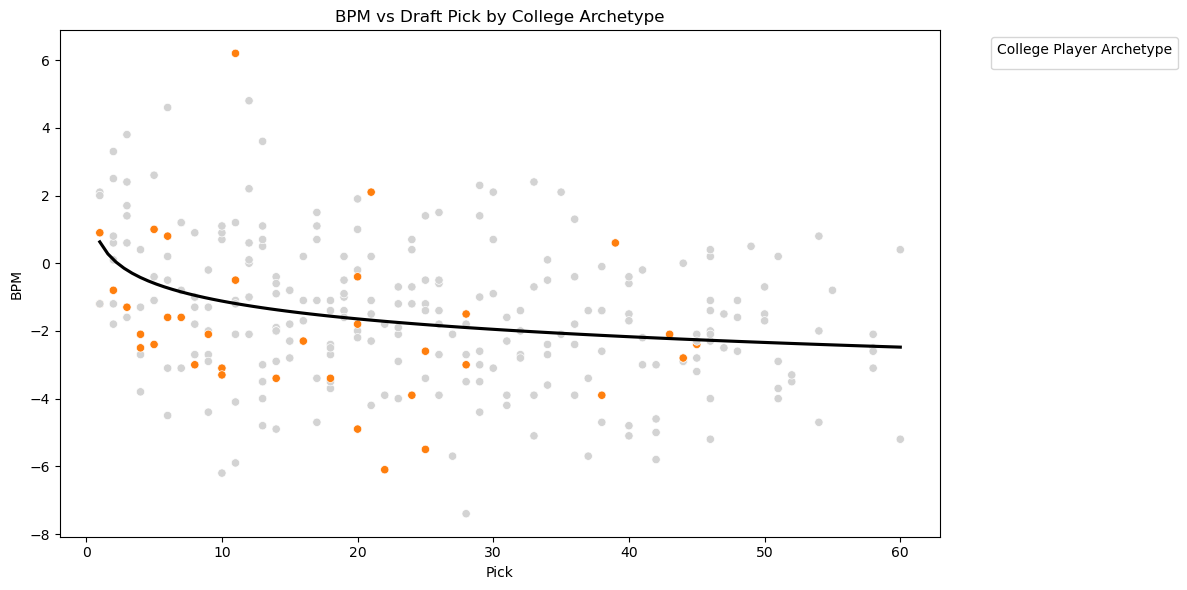

In [151]:
archetype = "Young, Unproven Shooter"

advanced_data["Color"] = advanced_data["Archetype"].apply(lambda x: 'tab:blue' if x == archetype else 'lightgrey')


plt.figure(figsize=(12,6))
ax = sns.scatterplot(data=advanced_data, x='Pick', y='BPM', hue='Color', palette=['lightgrey', 'tab:orange'], legend=False)
sns.regplot(data=advanced_data, x='Pick', y='BPM', scatter=False, logx = True, color='black', ci=None)

plt.title('BPM vs Draft Pick by College Archetype')

ax.legend(title="College Player Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()